In [2]:
# all imports
import argparse
import numpy as np
import pandas as pd
import models.autoencoder as vae
import models.nfl as nfl
import models.credence as credence
import seaborn as sns
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
from common.utils import sample_hyperparameter

In [3]:
# define function for showing probability distributions

def view_distribution(gt_df, generated_df, colnames, figsize = (15,30)):

    # print(X[:,0].shape, generated_df[1]["X1"].shape)
    # print('true value range', X[:, 0].min(), X[:, 0].max())
    # print('gen value range', generated_df[0]["X1"].min(), generated_df[0]["X1"].max())

    #plt.show()
    nrows = len(colnames)
    size = figsize
    fig,ax = plt.subplots(nrows=nrows,ncols=2,figsize=size)

    for i,yvar in enumerate(colnames):
        sns.kdeplot(gt_df[yvar], ax = ax[i,0], fill = True)
        ax[i,0].set_title(f'Observed {yvar}')
        sns.kdeplot(generated_df[yvar], ax = ax[i,1], fill = True)
        ax[i,1].set_title(f'Generated {yvar}')

    #plt.show()


In [20]:
# conduct experiment

def use_nfl(gt_df, x_vars, y_vars, out_vars, treat_vars, categorical_vars, num_vars, sample_params, max_epochs):
    nfl_obj = nfl.NFL(
        data = gt_df,
        outcome_var = out_vars,
        treatment_var = treat_vars,
        categorical_var = categorical_vars,
        numerical_var=x_vars+num_vars
    )
    #sample_params = sample_hyperparameter(['kld_rigidity'], [(0.0,1.0)])
    #max_epochs = 5 
    print('\n\nHyperparameters')
    print('kld rigidity:', sample_params['kld_rigidity'])
    print('max epochs', max_epochs, '\n\n')
    gen_models = nfl_obj.fit(kld_rigidity = sample_params['kld_rigidity'], max_epochs = max_epochs)

    # generated samples
    generated_df, generated_df_prime = nfl_obj.sample()
    generated_df_prime['Y'] = (generated_df_prime['A'] * generated_df_prime['Y1']) + ((1 - generated_df_prime['A']) * generated_df_prime['Y0'])
    generated_df_prime['Y_cf'] = (generated_df_prime['A'] * generated_df_prime['Yprime1']) + ((1 - generated_df_prime['A']) * generated_df_prime['Yprime0'])
    view_distribution(gt_df, generated_df_prime, y_vars, (10,10))

def use_credence(gt_df, x_vars, y_vars, out_vars, treat_vars, categorical_vars, num_vars, sample_params, max_epochs):
    cred_obj = credence.Credence(
        data = gt_df,
        outcome_var = out_vars,
        treatment_var = treat_vars,
        categorical_var = categorical_vars,
        numerical_var=x_vars+num_vars
    )
    #sample_params = sample_hyperparameter(['kld_rigidity'], [(0.0,1.0)])
    #max_epochs = 5
    print('\n\nHyperparameters')
    print('kld rigidity:', sample_params['kld_rigidity'])
    print('max epochs', max_epochs, '\n\n')
    gen_models = cred_obj.fit(kld_rigidity = sample_params['kld_rigidity'], max_epochs = max_epochs)

    # generated samples
    generated_df, generated_df_prime = cred_obj.sample()
    generated_df_prime['Y'] = (generated_df_prime['A'] * generated_df_prime['Y1']) + ((1 - generated_df_prime['A']) * generated_df_prime['Y0'])
    generated_df_prime['Y_cf'] = (generated_df_prime['A'] * generated_df_prime['Yprime1']) + ((1 - generated_df_prime['A']) * generated_df_prime['Yprime0'])
    view_distribution(gt_df, generated_df_prime, x_vars, (25,50))
    view_distribution(gt_df, generated_df_prime, y_vars, (10,10))

In [5]:
# define datasets
#w = widgets.IntSlider()
datasets = ['acic19_linear', 'acic19_polynomial', 'toy']
wd = widgets.Dropdown(
    options=datasets,
    value='acic19_linear',
    description='Dataset:',
)
frameworks = ['nfl', 'credence']
wf = widgets.Dropdown(
    options = frameworks,
    value = 'nfl', 
    description = 'Framework: '
)
display(wd)
display(wf)
dataset_type = wd.value
framework_type = wf.value


Dropdown(description='Dataset:', options=('acic19_linear', 'acic19_polynomial', 'toy'), value='acic19_linear')

Dropdown(description='Framework: ', options=('nfl', 'credence'), value='nfl')

In [22]:
sample_params = sample_hyperparameter(['kld_rigidity'], [(0.0,1.0)])
max_epochs = 100

/work/pi_jensen_umass_edu/vmuralikrish_umass_edu/.conda/envs/mlprojects/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /work/pi_jensen_umass_edu/vmuralikrish_umass_edu/.co ...
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/work/pi_jensen_umass_edu/vmuralikrish_umass_edu/.conda/envs/mlprojects/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /work/pi_jensen_umass_edu/vmuralikrish_umass_edu/playground/nofl-pg/lightning_logs/version_25465967/checkpoints exists and is not empty.

  | Name      | Type       | Params | Mode 
-------------------------------------------------
0 | encoder   | Sequential | 16     | train
1 | en_mu     | Linear     | 36     | train
2 | e



Dataset to be used:  acic19_linear
Framework to be used:  credence


Hyperparameters
kld rigidity: 0.7913779124209861
max epochs 100 




/work/pi_jensen_umass_edu/vmuralikrish_umass_edu/.conda/envs/mlprojects/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:475: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
`Trainer.fit` stopped: `max_epochs=100` reached.
/work/pi_jensen_umass_edu/vmuralikrish_umass_edu/.conda/envs/mlprojects/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /work/pi_jensen_umass_edu/vmuralikrish_umass_edu/.co ...
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/work/pi_jensen_umass_edu/vmuralikrish_umass_edu/.conda/envs/mlprojects/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: 

no of samples:  668


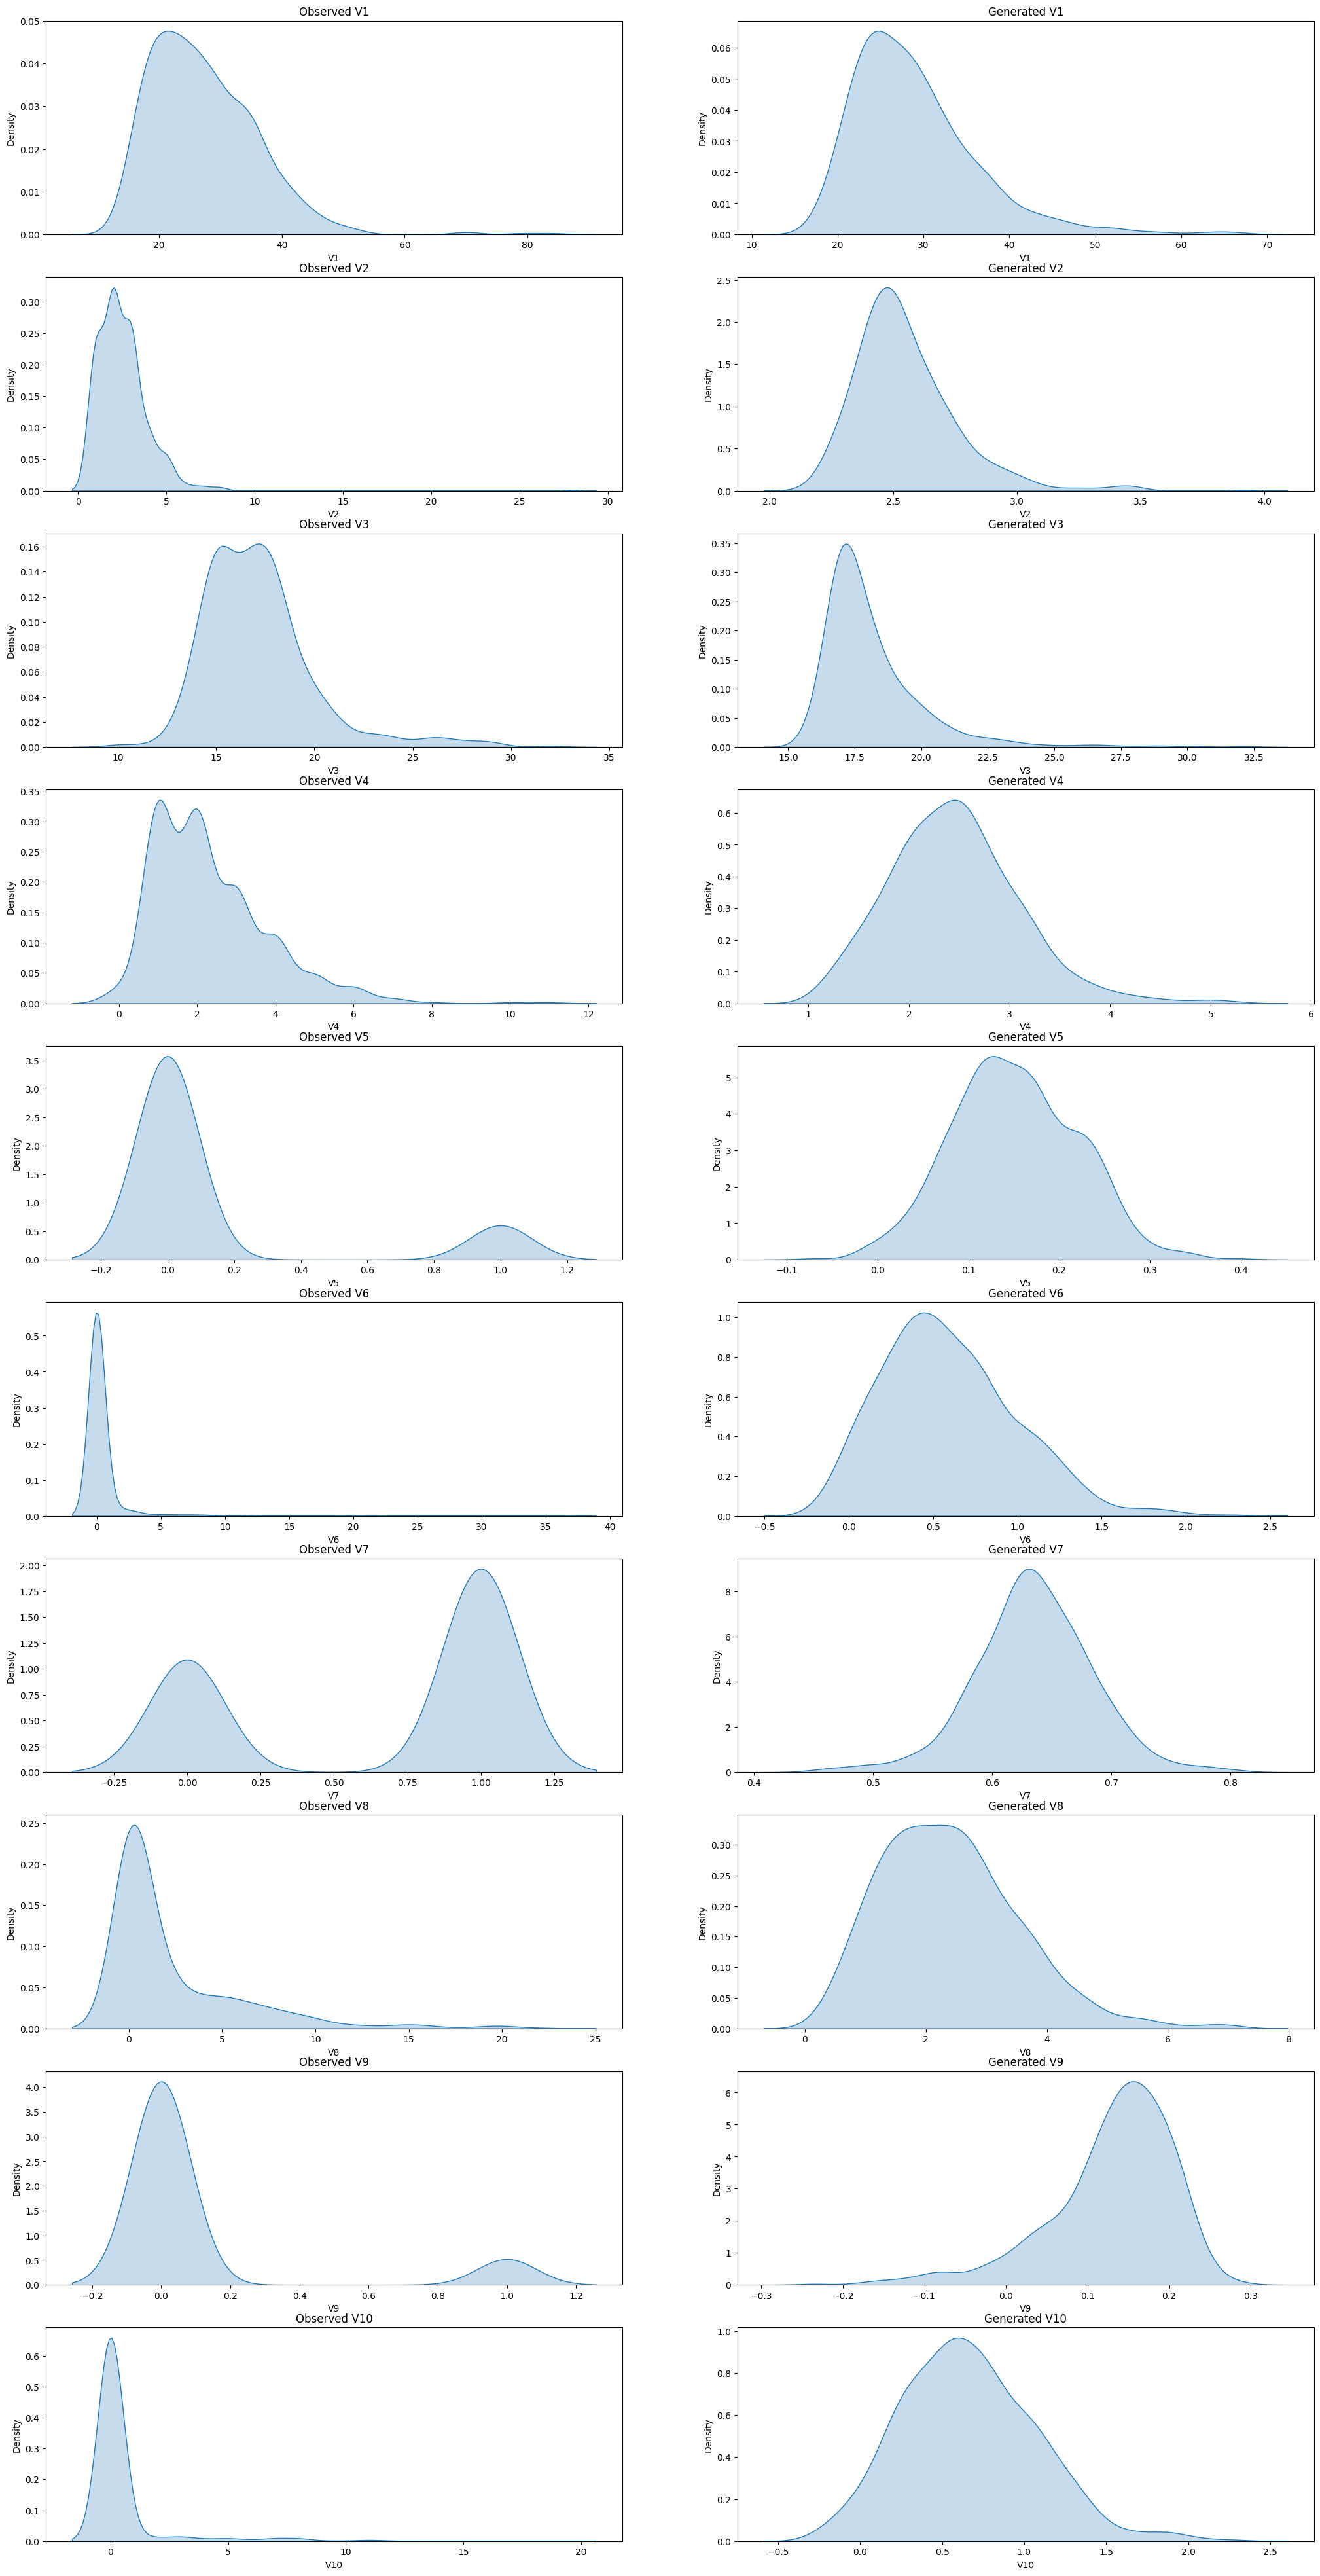

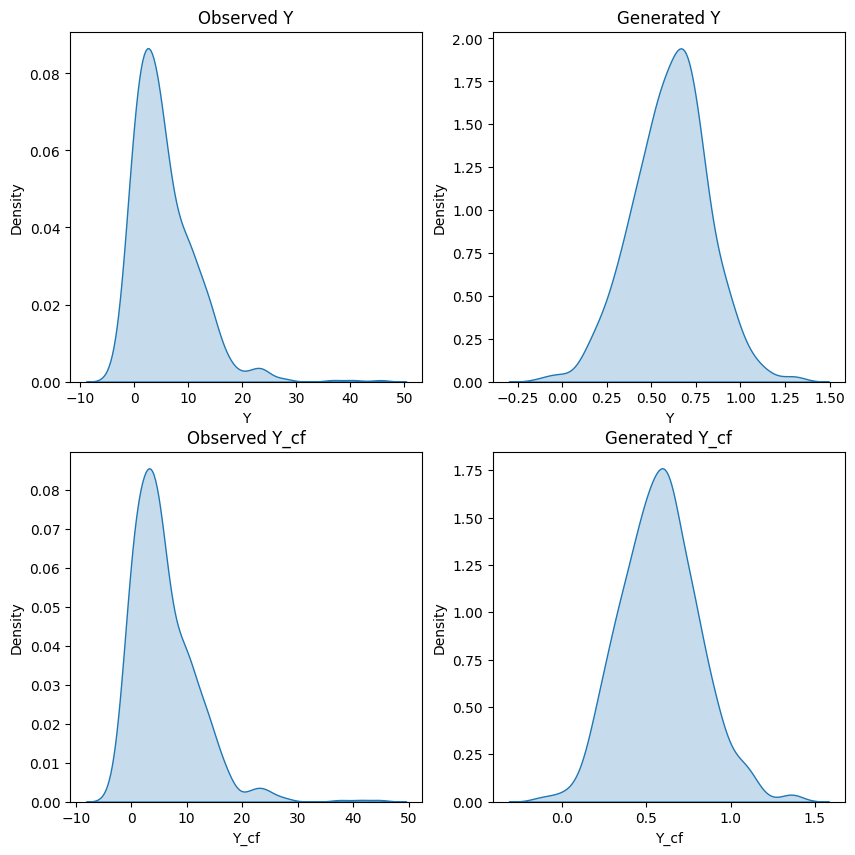

In [23]:
print('\n\nDataset to be used: ', wd.value)
print('Framework to be used: ', wf.value)

if wd.value == 'toy':
    # generating toy dataset
    X = np.random.normal(0, 1, (2000, 5))
    Y0 = np.random.normal(np.sum(X,axis=1),1)
    T = np.random.binomial(1,0.5,size=(X.shape[0],))
    Y1 = Y0**2 + np.random.normal(np.mean(X,axis=1),5)
    Y = T*Y1 + (1 - T)*Y0
    xnames = ['X%d'%(i) for i in range(X.shape[1])]
    ynames = ['Y', 'Y_cf']

    gt_df = pd.DataFrame(X, columns=['X%d'%(i) for i in range(X.shape[1])])
    gt_df['Y'] = T*Y1 + (1 - T)*Y0
    gt_df['T'] = T

    if wf.value == 'nfl':
        use_nfl(gt_df, xnames, ynames, ['Y'], ['T'], ['T'], ['Y'], sample_params, max_epochs)
    elif wf.value == 'credence':
        use_credence(gt_df, xnames, ynames, ['Y'], ['T'], ['T'], ['Y'], sample_params, max_epochs)
    else:
        SystemExit('Invalid framework type provided!')
elif wd.value == 'acic19_linear':
    gt_df = pd.read_csv('./data/datasets/acic19_low_dim_1_linear.csv')

    x_vars = ['V%d'%(i) for i in range(1,11)]
    y_vars = ['Y', 'Y_cf']

    if wf.value == 'nfl':
        use_nfl(gt_df, x_vars, y_vars, ['Y'], ['A'], ['A'], ['Y'], sample_params, max_epochs)
    elif wf.value == 'credence':
        use_credence(gt_df, x_vars, y_vars, ['Y'], ['A'], ['A'], ['Y'], sample_params, max_epochs)
    else:
        SystemExit('Invalid framework type provided!')
else:
    SystemExit('Invalid dataset value provided!')